In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dataset = pd.read_csv('dataset.csv')

Firstly we create a new dataset with only the numerical features

In [3]:
dataset_numeric = dataset[['track_id', 'duration_ms', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'popularity']]

We notice that there are a lot of duplicate id, probably because of the column we dropped so we try drop all the duplicate record and see if this solves

In [4]:
dataset_numeric.track_id.value_counts()

6S3JlDAGk3uu3NtZbPnuhS    9
2Ey6v4Sekh3Z0RUSISRosD    8
2kkvB3RNRzwjFdGhaUA0tz    8
5ZsAhuQ24mWHiduaxJqnhW    7
08kTa3SL9sV6Iy8KLKtGql    7
                         ..
0kJ7eKX6aWl8X1W5Xrosn6    1
4bYH5445Bn2w9UiGM0NxQw    1
1T5C6ENvpM3IiYeezsK9uI    1
34SatKRJgtXfL0bcgk7HMA    1
2hETkH7cOfqmz3LqZDHZf5    1
Name: track_id, Length: 89741, dtype: int64

In [5]:
dataset_numeric = dataset_numeric.drop_duplicates()

There are still some duplicates so we take one case in analysis

In [6]:
dataset_numeric.track_id.value_counts()

0ganZjtkMwkoRvYQk7te7h    2
3dwDBE5AMcHLxemIAEp2xb    2
65YXrDsZER1jlPAqFS9GDH    2
1S7hEPenrIVKVTuEjtXKz9    2
2ivnsOi3RcEbskFvTS9zt3    2
                         ..
5dTHtzHFPyi8TlTtzoz1J9    1
1m5HcIPX2T3wSoiHWhgwpA    1
0DWrG09StYVhLbeNLwAJ5w    1
6eYxmK9fdL4hwLnXG2zY3s    1
2hETkH7cOfqmz3LqZDHZf5    1
Name: track_id, Length: 89741, dtype: int64

In [7]:
dataset_numeric.loc[dataset['track_id'] == dataset_numeric.track_id.value_counts().keys()[0]]

,track_id,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,popularity
9167,0ganZjtkMwkoRvYQk7te7h,142131,0.768,0.52,-7.375,0.0994,0.0912,0.000001,0.435,0.776,140.109,49
87175,0ganZjtkMwkoRvYQk7te7h,142131,0.768,0.52,-7.375,0.0994,0.0912,0.000001,0.435,0.776,140.109,48


The only feature differentiating the two records is the popularity, it is conceptually wrong, and also impossible to learn for the model that two identical songs have different popularity score so we decide to keep only the one with higher popularity

In [8]:
idx = dataset_numeric.groupby(['track_id'])['popularity'].transform(max) == dataset_numeric['popularity']
dataset_numeric = dataset_numeric[idx]
dataset_numeric.track_id.value_counts()

5SuOikwiRyPMVoIQDJUgSV    1
5hISmTJXBXdOes4htbUhGk    1
062WEhWJ0tNa0CaAEuMwYB    1
7pS3O75hJnthHr64tlpqPn    1
6rsoBvxrlxdmqJyGPPciyq    1
                         ..
46s77n3x4XZqUhZfIOCax9    1
3f1ChZHm6v4KdUaEW5y5qd    1
2v5JTeM6hSmi5wWy7jiwrI    1
70Jmz6ibehHG03l4Mtr9qv    1
2hETkH7cOfqmz3LqZDHZf5    1
Name: track_id, Length: 89741, dtype: int64

We create the predictors vector and the target variable to pass to the function

In [9]:
predictors = dataset_numeric.columns.values.tolist()
predictors.remove('track_id')
predictors.remove('popularity')
target = 'popularity'

We define the function for the regression

In [10]:
def ridge_fit(dataset, predictors_features, target_feature, alpha):
    S = dataset[predictors_features].copy()
    y = dataset[[target_feature]].copy()
    
    s_mean = S.mean()
    s_std = S.std()
    
    S = (S - s_mean) / s_std      #normalization
    S['intercept'] = 1
    S = S[['intercept'] + predictors]
    
    
    penalty = alpha * np.identity(S.shape[1])
    penalty[0][0] = 0
    w = np.linalg.inv(S.T @ S + penalty) @ S.T @ y
    return w, s_mean, s_std

In [11]:
def ridge_predict(dataset, predictors_features, trainset_mean, trainset_std, w):
    testset = dataset[predictors_features]
    testset = (testset - trainset_mean) / trainset_std
    testset['intercept'] = 1
    testset = testset[['intercept'] + predictors_features]
    w.index = ['intercept'] + predictors
    predictions =  testset @ w
    return predictions

Now we try to find the optimal alpha using cross validation(this process has been repeated for various range of alpha, trying to focus on the set where the error was lower, here it is reported only the last set as example)

In [31]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, shuffle = True, random_state =1)
risk = []
alphas =[]
for alpha in range(1, 400, 10):
    loss = 0
    for train_index, test_index in kf.split(dataset_numeric):
        train, test = (dataset_numeric.iloc[train_index]), (dataset_numeric.iloc[test_index])
        w, mean, std = ridge_fit(train, predictors, target, alpha)
        prediction = ridge_predict(test, predictors, mean, std, w)
        loss_i = (5/dataset_numeric.shape[0]) * sum(pow((prediction.popularity - test.popularity),2))
        loss = loss + loss_i

    cv = 1/5 * loss
    risk.append(pow(cv, 1/2))
    alphas.append(alpha)

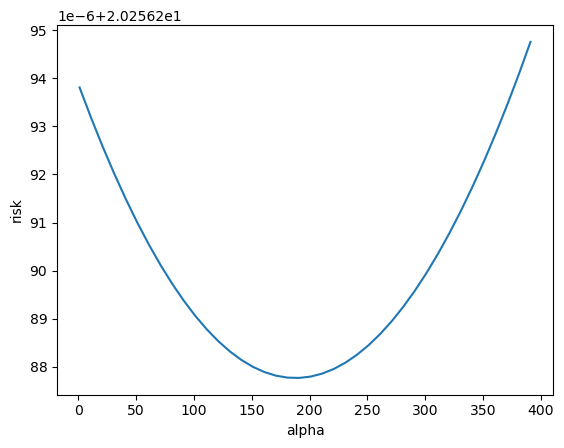

In [32]:
plt.plot(alphas, risk)
plt.xlabel('alpha')
plt.ylabel('risk')
plt.show()

Now we use 5-fold cross validation to extimate the risk of our predictor using alpha = 180, the best value from the previous analysis

In [34]:
loss = 0
for train_index, test_index in kf.split(dataset_numeric):
    train, test = (dataset_numeric.iloc[train_index]), (dataset_numeric.iloc[test_index])
    w, mean, std = ridge_fit(train, predictors, target, 180)
    prediction = ridge_predict(test, predictors, mean, std, w)
    loss_i = (5/dataset_numeric.shape[0]) * sum(pow((prediction.popularity - test.popularity),2))
    loss = loss + loss_i

cv = 1/5 * loss
print(pow(cv, 1/2))

20.25566660656646